In [1]:
from google.cloud import language_v1
import os
import re

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = './cueback-app-e91f3f8c0155.json'

In [3]:
client = language_v1.LanguageServiceClient()

In [4]:
def extract_entity(text):
    global client
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    return client.analyze_entities(request={'document': document})

def extract_sentiment(text):
    global client
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    return client.analyze_sentiment(request={'document': document})

In [10]:
def entity_sentiment(text):
    if len(text.split()) > 0:
        r1 = extract_entity(text)
        entities_sentiment={}
        for e in r1.entities:
            #print(e)
            if str(e.type_) in ['Type.PERSON', 'Type.ORGANIZATION', 'Type.LOCATION', 'Type.DATE']:
                sentiments = []
                for mention in e.mentions:
                    #print(str(mention.type_))
                    if str(mention.type_) == "Type.PROPER":
                        try:
                            sentences = re.findall(r"([^.]*?"+mention.text.content+"[^.]*\.)",text)  
                            for s in sentences:
                                sentiment = extract_sentiment(s)
                                sentiments.append(sentiment.document_sentiment.score)
                        except:
                            pass
                if len(sentiments) != 0:
                    entities_sentiment[(e.name.lower(),str(e.type_).split(".")[1])] = sum(sentiments) / len(sentiments)
        entities_sentiment = dict(sorted(entities_sentiment.items(), key=lambda item: item[1], reverse=True))
        print(entities_sentiment)
        return entities_sentiment

# Aggregated Test using data from the App pilot

In [11]:
import pandas as pd 
from tqdm import tqdm

In [12]:
tqdm.pandas()

In [13]:
test_df = pd.read_csv('data/platform data.csv')
test_df.columns

Index(['Unnamed: 0', 'Title', 'Len', 'Ed', 'Woody', 'Photo'], dtype='object')

In [14]:
len(test_df)

14

## Analysis

In [15]:
test_df['len_insights'] = test_df['Len'].apply(entity_sentiment)

{('steve stagnero', 'PERSON'): 0.6000000238418579, ('kcpr', 'ORGANIZATION'): 0.22000000327825547, ('the lounge', 'ORGANIZATION'): 0.0, ('blood, sweat & tears', 'ORGANIZATION'): -0.10000000149011612, ('beach boys', 'ORGANIZATION'): -0.10000000149011612, ('the who', 'ORGANIZATION'): -0.10000000149011612, ('andy williams', 'PERSON'): -0.10000000149011612, ('winter quarter', 'PERSON'): -0.20000000298023224}
{('jim stueck', 'PERSON'): 0.0, ('alan holmes', 'PERSON'): 0.0, ('kcpr', 'ORGANIZATION'): 0.0, ('woody goulart', 'PERSON'): 0.0}
{('radio hill', 'LOCATION'): 0.0, ('emergency broadcast system', 'ORGANIZATION'): 0.0, ('eric dausman', 'PERSON'): 0.0, ('steve ruegnitz', 'PERSON'): 0.0, ('chevy', 'ORGANIZATION'): 0.0, ('dean opperman', 'PERSON'): 0.0, ('al lindley', 'PERSON'): 0.0, ('steve witten', 'PERSON'): 0.0, ('ron margaretten', 'PERSON'): 0.0, ('mustang daily', 'ORGANIZATION'): -0.10000000149011612, ('kcpr', 'ORGANIZATION'): -0.17499999701976776, ('kvec', 'ORGANIZATION'): -0.175000000

{('al beckner', 'PERSON'): 0.20000000298023224}


In [16]:
test_df['Ed'] = test_df['Ed'].astype(str)
test_df['ed_insights'] = test_df['Ed'].apply(entity_sentiment)

{('ksan', 'ORGANIZATION'): 0.800000011920929, ('ksjo', 'ORGANIZATION'): 0.800000011920929, ('graphic arts bldg', 'ORGANIZATION'): -0.10000000149011612}


ResourceExhausted: 429 Quota exceeded for quota metric 'Requests' and limit 'Requests per minute' of service 'language.googleapis.com' for consumer 'project_number:298180869348'.

In [ ]:
test_df['Woody'] = test_df['Ed'].astype(str)
test_df['woody_insights'] = test_df['Woody'].apply(entity_sentiment)

In [17]:
test_df.to_csv('analyzed platform data.csv')

## Aggregation

In [18]:
entities_dict = {}
dfs=[]
def get_dfs(d):
    global dfs
    entities_df = pd.DataFrame.from_dict(d, orient='index').reset_index().rename({'index':'entity',0:'sentiment'},axis=1)
    dfs.append(entities_df)
    
test_df['len_insights'].apply(get_dfs)

entities_df = pd.concat(dfs)

In [19]:
entities_df['entity_type'] = entities_df['entity'].apply(lambda x: x[1])
entities_df['entity'] = entities_df['entity'].apply(lambda x: x[0])

In [20]:
agg_entities_df = entities_df.groupby(['entity','entity_type']).agg(['mean', 'count']).reset_index()
agg_entities_df.columns = agg_entities_df.columns.droplevel(0)
agg_entities_df.columns = ['entity','entity_type','sentiment', 'count']
agg_entities_df.sort_values('sentiment', ascending=False , inplace=True)
count_entities_df = agg_entities_df.sort_values('count', ascending=False )

In [21]:
agg_entities_df.to_csv('aggregated entities in platform data.csv')

In [22]:
agg_entities_df[agg_entities_df['entity_type']=="PERSON"].to_csv('people in platform data.csv')

# Visuals

Top 10 Entities by sentiment

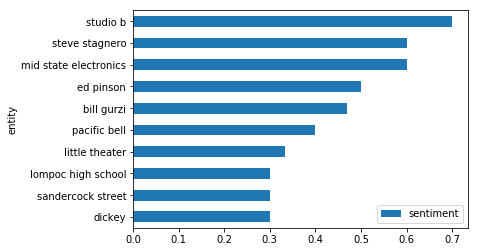

In [25]:
plt= agg_entities_df.head(10).sort_values('sentiment').plot.barh(x='entity', y='sentiment')


Top 10 Entities by count

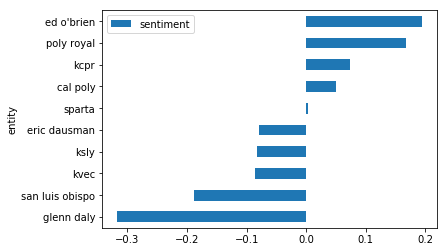

In [26]:
count_entities_df.head(10).sort_values('sentiment').plot.barh(x='entity', y='sentiment')

Least 10 Entities by sentiment

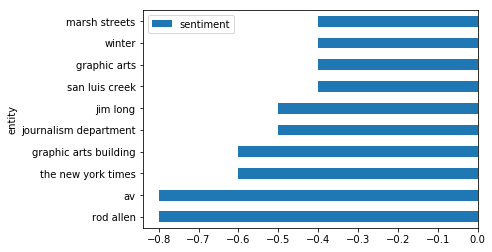

In [27]:
count_entities_df.sort_values('sentiment').head(10).plot.barh(x='entity', y='sentiment')